In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

In [2]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)

zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')
zarr_ds = zarr_ds.sel(time=slice('2020-01-01', '2022-12-31'))

In [18]:
zarr_ds['sst'][0]

<xarray.DataArray 'sst' (lat: 149, lon: 181)>
dask.array<getitem, shape=(149, 181), dtype=float32, chunksize=(149, 181), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.0 31.75 31.5 31.25 31.0 ... -4.25 -4.5 -4.75 -5.0
  * lon      (lon) float32 45.0 45.25 45.5 45.75 46.0 ... 89.25 89.5 89.75 90.0
    time     datetime64[ns] 2020-01-01
Attributes:
    long_name:       Sea surface temperature
    nameCDM:         Sea_surface_temperature_surface
    nameECMWF:       Sea surface temperature
    product_type:    analysis
    shortNameECMWF:  sst
    standard_name:   sea_surface_temperature
    units:           K

In [3]:
import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

processed_data = preprocess_data(zarr_ds).compute()

def prepare_data_from_processed(processed_data, window_size=5): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

In [4]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

def masked_mse(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0.0))
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))

def transformer_model(input_shape, num_heads=4, feed_forward_dim=256):
    inputs = layers.Input(shape=input_shape)
    
    # Flatten the spatial dimensions
    x_flattened = layers.TimeDistributed(layers.Flatten())(inputs)
    
    # Transformer block
    x_transformed = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(x_flattened, x_flattened)
    
    # Reshape x_transformed back to its original spatial dimensions
    x_reshaped = layers.TimeDistributed(layers.Reshape((input_shape[1], input_shape[2])))(x_transformed)
    x_normalized = layers.LayerNormalization()(x_reshaped + inputs)
    x_normalized_flattened = layers.TimeDistributed(layers.Flatten())(x_normalized)
    
    ffn_output = layers.Dense(feed_forward_dim, activation="relu")(x_normalized_flattened)
    ffn_output = layers.Dense(input_shape[-1])(ffn_output)
    
    x = layers.LayerNormalization()(ffn_output)
    
    # Reduce the time dimension
    x = layers.GlobalAveragePooling1D()(x)
    
    # Decoding: Ensure the Dense layer outputs the exact number of units for reshaping
    x = layers.Dense(input_shape[1] * input_shape[2])(x)
    outputs = layers.Reshape((input_shape[1], input_shape[2]))(x)
    
    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

model = transformer_model((5, 149, 181))



2023-07-31 16:27:51.132451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 16:27:51.182477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 16:27:51.183413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 16:27:52.031041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
              loss=masked_mse,
              metrics=['mae'])

X_train_np = X_train.compute()
y_train_np = y_train.compute()
X_val_np = X_val.compute()
y_val_np = y_val.compute()

history = model.fit(X_train_np, y_train_np, 
                    validation_data=(X_val_np, y_val_np), 
                    epochs=20, batch_size=32)

Epoch 1/20
21/21 [==============================] - 12s 511ms/step - loss: 0.1268 - mae: 0.2073 - val_loss: 0.2312 - val_mae: 0.2753
Epoch 2/20
21/21 [==============================] - 10s 499ms/step - loss: 0.1137 - mae: 0.1957 - val_loss: 0.2265 - val_mae: 0.2728
Epoch 3/20
21/21 [==============================] - 10s 496ms/step - loss: 0.1066 - mae: 0.1891 - val_loss: 0.2188 - val_mae: 0.2678
Epoch 4/20
21/21 [==============================] - 10s 492ms/step - loss: 0.1013 - mae: 0.1854 - val_loss: 0.2264 - val_mae: 0.2753
Epoch 5/20
21/21 [==============================] - 10s 491ms/step - loss: 0.0950 - mae: 0.1794 - val_loss: 0.2223 - val_mae: 0.2680
Epoch 6/20
21/21 [==============================] - 10s 491ms/step - loss: 0.0916 - mae: 0.1758 - val_loss: 0.2240 - val_mae: 0.2729
Epoch 7/20
21/21 [==============================] - 10s 498ms/step - loss: 0.0878 - mae: 0.1726 - val_loss: 0.2341 - val_mae: 0.2789
Epoch 8/20
21/21 [==============================] - 10s 495ms/step - 

In [14]:
min_value = np.min(X_train_np)
max_value = np.max(X_train_np)
print(f"Data range: {min_value} to {max_value}")

Data range: -29.75201416015625 to 7.63726806640625


1/1 [==============================] - 0s 30ms/step


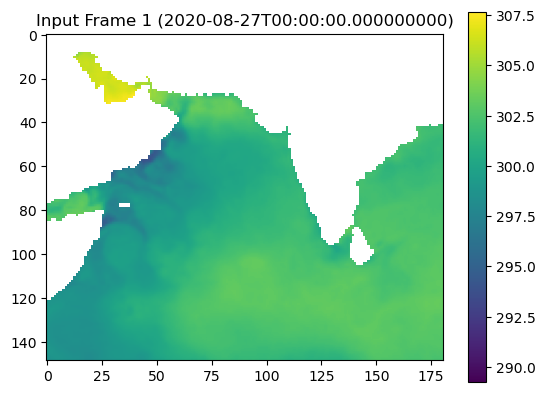

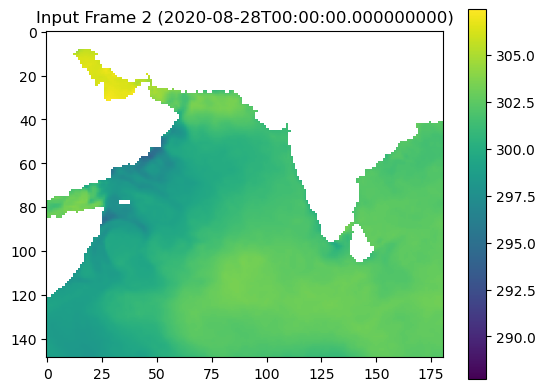

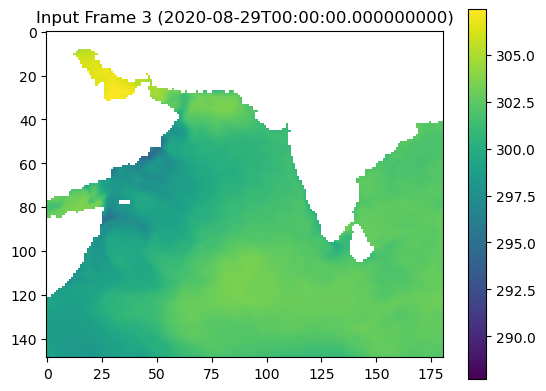

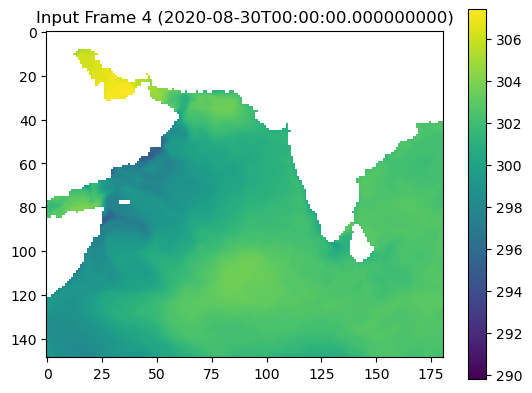

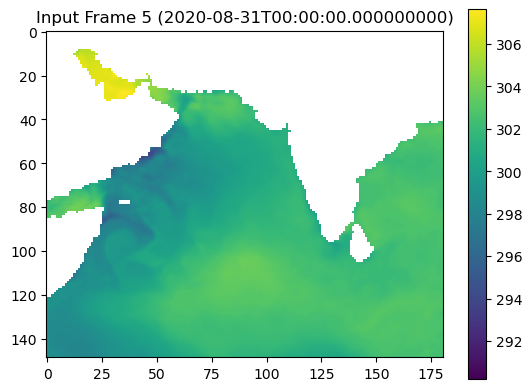

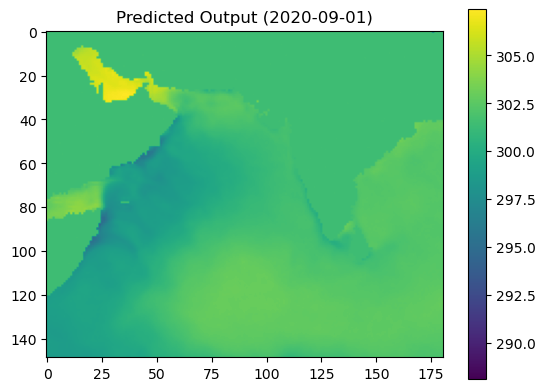

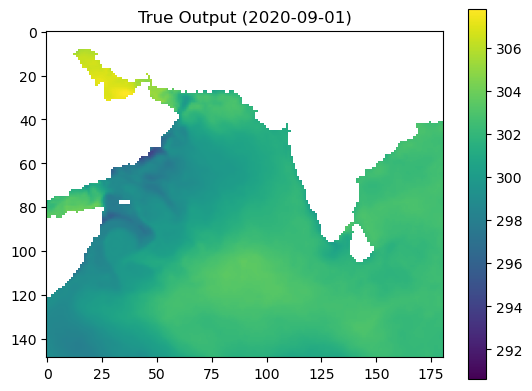

In [29]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_data(predicted_data, input_data):
    # Convert values that were 0 (originally NaN) back to NaN
    processed_data = np.where(predicted_data == 0.0, np.nan, predicted_data)
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    processed_data += mean_val

    return processed_data


def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values
    
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_data(prediction, true_output_raw)
    
    # Step 3: Visualize
    if plot:
        def plot_sample(sample, title=''):
            plt.imshow(sample, cmap='viridis')
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data, prediction, true_output_raw

date_to_predict = '2020-09-01'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, zarr_ds)

In [39]:
y_train

dask.array<getitem, shape=(652, 149, 181), dtype=float32, chunksize=(652, 149, 181), chunktype=numpy.ndarray>

In [15]:
sample_index = 0
sample_input = X_val_np[sample_index:sample_index+1]
sample_true_output = y_val_np[sample_index]

sample_prediction = model.predict(sample_input)[0]

1/1 [==============================] - 0s 216ms/step


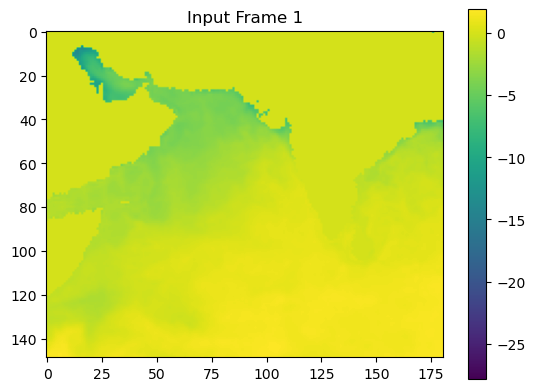

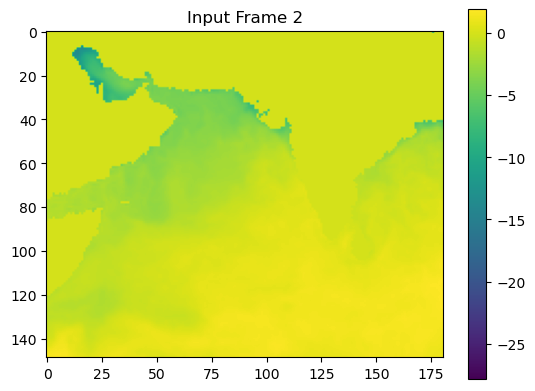

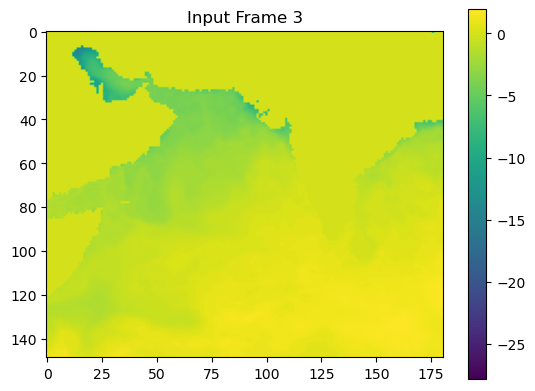

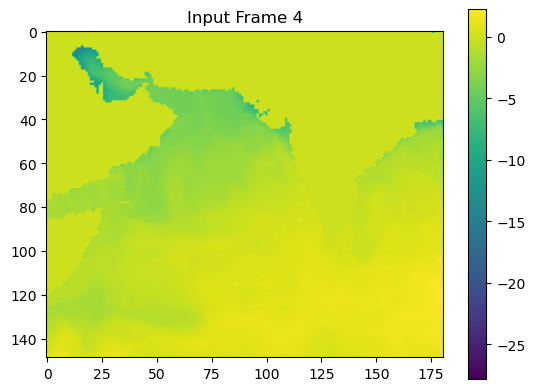

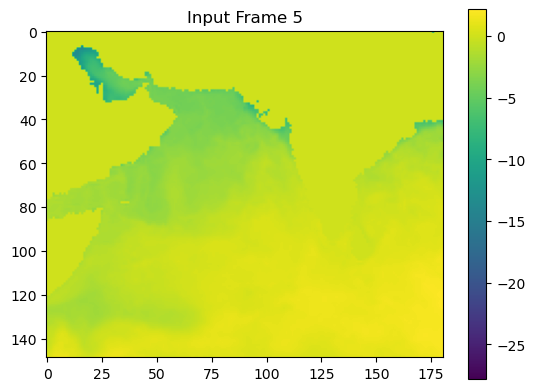

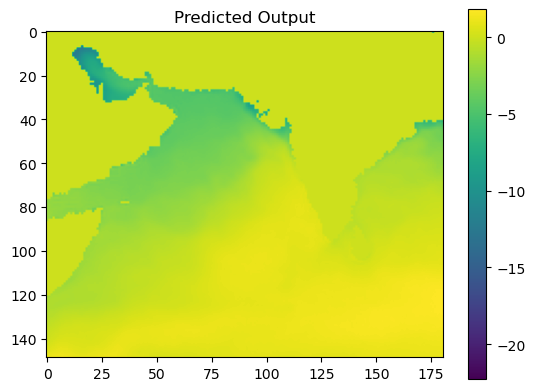

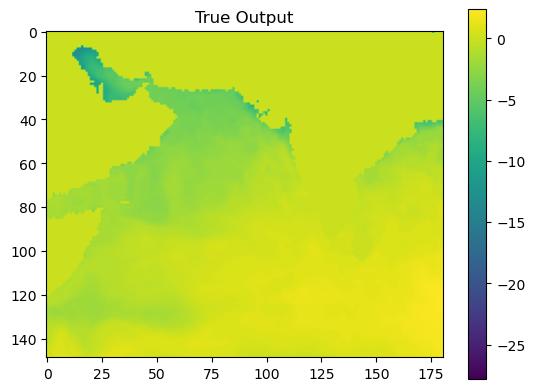

In [19]:
import matplotlib.pyplot as plt

def plot_sample(sample, title=''):
    plt.imshow(sample, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()
    
# show input
for i, frame in enumerate(sample_input[0]):
    plot_sample(frame, title=f'Input Frame {i+1}')

# show predicted output
plot_sample(sample_prediction, title='Predicted Output')

# show true output
plot_sample(sample_true_output, title='True Output')

In [44]:
X_train[0]

dask.array<getitem, shape=(5, 149, 181), dtype=float32, chunksize=(5, 149, 181), chunktype=numpy.ndarray>